In [1]:
%load_ext autoreload

In [6]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from scipy.signal import freqs
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.manifold import Isomap
from spynal.spikes import density
import sys
from tqdm.auto import tqdm

sys.path.append('/om2/user/eisenaj/code/ChaoticConsciousness/')
sys.path.append('/Users/adameisen/Documents/MIT/code/ChaoticConsciousness')
from data_utils import *

sys.path.append('/om2/user/eisenaj/code/DeLASE')
sys.path.append('/Users/adameisen/Documents/MIT/code/DeLASE')
from delase import *
from utils import numpy_torch_conversion
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# plt.style.use('/om2/user/eisenaj/code/ChaoticConsciousness/sci_style.py')

# Functions

In [7]:
class PCA:
    def __init__(self, n_components=None, use_torch=False, device='cpu', dtype='torch.DoubleTensor'):
        self.n_components = n_components
        self.use_torch = use_torch
        self.device = device
        self.dtype = dtype
        
    def compute_multidim_mean(self, data):
        return data.mean(axis=tuple(np.arange(0, len(data.shape)-1)))
    
    def fit(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)   
        data_centered = data - self.compute_multidim_mean(data)
        if self.use_torch:
            U, S, Vh = torch.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T

        else:
            U, S, Vh = np.linalg.svd(data_centered, full_matrices=False)
            self.U = U
            self.S = S
            self.V = Vh.T
        
        self.explained_variance_ = ((S**2)/(data.shape[0] - 1))[:self.n_components]
    
    def transform(self, data):
        data = numpy_torch_conversion(data, self.use_torch, self.device, self.dtype)
        data_centered = data - self.compute_multidim_mean(data)
        return (data_centered) @ self.V[:, :self.n_components]

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
def get_bins(spike_mat, bin_size):
    """
    Helper function for get_up_down_raw() function. 

    Calculate number of bins based on bin_size, remove extra
    data at end, and return spikes/bin count array.
    """
    trial_length = spike_mat.shape[1]
    n_bins = np.floor(trial_length / bin_size)

    cut_ind = int(n_bins*bin_size)

    clipped_spike_mat = spike_mat[:,:cut_ind]
    
    return sum_bins(clipped_spike_mat, n_bins)
    
def sum_bins(spike_mat, n_bins):
    """
    Helper function for get_bins() function. 

    Break apart spike_mat (0/1 spike array) into n_bins and
    return (n_bin,) length array containing spike counts per bin.
    """
    split = np.hsplit(spike_mat, n_bins)
    join = np.stack(split)
    
    return join.sum(axis=(1,2))

def get_up_down_raw(area_spike_dict, bin_size=200, Fs=1000, thresh=0.1, 
                trange=None, smooth=True):
    """
    For each spike array in area_spike_dict, get 0/1 Up/Down array at bin_size 
    resolution.
    Optional smooth: fill in 101 case with 111
    Returns dictionary with Up/Down raw array per region.
    """
    
    areas = list(area_spike_dict.keys())

    data_length = area_spike_dict[areas[0]].shape[1]
    # n_bins = int(np.floor(data_length / bin_size))
    
    if trange is None:
        trange = np.arange(data_length)
    
    binned_up_down_dict = {}
    
    for a, spikes in area_spike_dict.items():
        if a == '7b':
            thresh = 0.2
        else:
            thresh = thresh

        binned = get_bins(spikes, bin_size)
        binned_up_down_dict[a] = (((binned / area_spike_dict[a].shape[0])\
                        * (200/bin_size)) > thresh).astype(float)

    if smooth:
        for a, binned in binned_up_down_dict.items():
            for n in range(binned.size):
                if n == 0 or n == binned.size-1:
                    pass
                else:
                    if binned[n-1] == 1 and binned[n+1] == 1:
                        binned[n] = 1

    up_down_dict = {k: np.repeat(v, bin_size) for k,v\
                    in binned_up_down_dict.items()}
    
    return up_down_dict

# NOTE - some shoddy conditionals for handling boundary issues
# WATCH FOR ISSUES
def get_up_edges(up_down_array):
    """
    Get indices for starts/ends of sequence of ones in up_down_array.
    Check / fix common errors due to boundary issues.
    """
    starts = np.where(np.diff(up_down_array) == 1)[0] + 1
    ends = np.where(np.diff(up_down_array) == -1)[0] + 1
    
    if ends[0] <= starts[0]:
        ends = ends[1:]
        starts = starts[:-1]
        
    if ends.size != starts.size:
        min_size = min(ends.size, starts.size)
        starts = starts[:min_size]
        ends = ends[:min_size]
    
    return starts, ends



def trim_up_down_array(expanded_up, area_spike_seg):
    """
    Remove trailing Up/Down labels based on 0-spike counts at 
    beginning/end of Up segement in Up/Down array.
    """
    trimmed_up = np.zeros(expanded_up.size)
    up_starts, up_ends = get_up_edges(expanded_up)
    # need to handle case where these aren't equal?
    for i in range(up_starts.size):
        s = up_starts[i]
        e = up_ends[i]
        up_seg = area_spike_seg[:,s:e]
        
        nonzeros = np.nonzero(up_seg.sum(0))[0]
        new_s = s + nonzeros[0]
        new_e = s + nonzeros[-1]
        
        trimmed_up[new_s:new_e] = 1
        
    return trimmed_up

def trim_up_down(expand_dict, area_spikes_dict):
    """
    Apply trim_up_down_array to each region in dictionary.
    """
    trimmed_dict = {}
    for a in expand_dict.keys():
        expand_up = expand_dict[a]
        spikes_seg = area_spikes_dict[a]
        
        trimmed_dict[a] = trim_up_down_array(expand_up, spikes_seg)
        
    return trimmed_dict

def get_up_down(area_spike_dict, bin_size=200):
    """
    Apply full Up/Down processing to each region in area_spike_dict.
    Returns new dictionary w/ full/processed Up/Down array per region.
    """
    raw_up_down_dict = get_up_down_raw(area_spike_dict, bin_size=bin_size)
    up_down_dict = trim_up_down(raw_up_down_dict, area_spike_dict)

    return up_down_dict

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def rnn(t, x, W, tau, g):
    return (1/tau)*(-x + g*W @ np.tanh(x))

def g_dW(x, scale=1):
    return scale

# Test over Contraction Rates

In [8]:
parameter_grid=ParameterGrid(
    window_vals=np.array([10000]),
    matrix_size_vals=np.array([50, 100, 150, 200, 250, 300, 350, 400]),
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 225, 250, 275, 300, 350, 400]),
)
transient = 2000
T_pred = 4000
device = 'cuda'

## Simulate Signals

In [9]:
N = 512
T = 20000
dt = 0.01
tau = 1
W = np.random.randn(N, N)

In [20]:
N = 64
T = 20000
dt = 0.01
tau = 1
W = np.random.randn(N, N)
W /= np.linalg.norm(W, ord=2)
lamb_vals = [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001]

signals = {}

for lamb in tqdm(lamb_vals):
    g = 1 - lamb
    dW = np.sqrt(dt) * np.random.randn(T,N)
    x0 = np.random.randn(N)
    # Define the function g(x)


    # Initialize the x array
    x = np.zeros((T, N))
    x[0] = np.random.randn(N)

    # Simulate the stochastic differential equation
    for i in range(1, T):
        x[i] = x[i-1] + rnn((i - 1)*dt, x[i-1], W, tau, g) * dt + g_dW(x[i-1], scale=0.05) * dW[i]

    signals[lamb] = x

  0%|          | 0/8 [00:00<?, ?it/s]

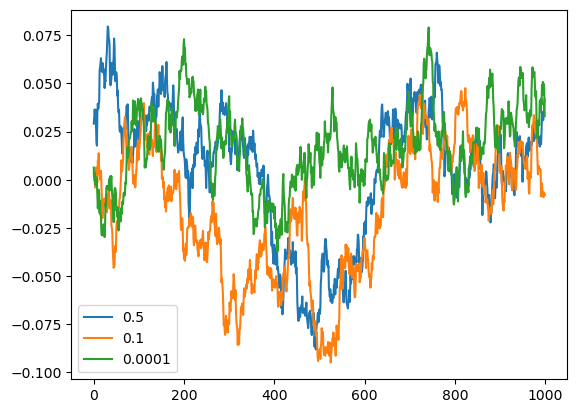

In [21]:
start = 2000
end = 3000
for lamb in [0.5, 0.1, 0.0001]:
    plt.plot(signals[lamb][start:end, 0], label=lamb)
plt.legend()
plt.show()

## Compute DeLASE

In [22]:
num_indices = 64
differentiable = False

In [23]:
window = parameter_grid.window_vals[0]
iterator = tqdm(total=len(signals)*len(parameter_grid.matrix_size_vals)*len(parameter_grid.r_vals))

results = {}
for lamb, x in signals.items():
    np.random.seed(42 + int(1/lamb))
    indices = np.random.choice(np.arange(N), size=(num_indices, ), replace=False)
    signal = x[transient:, indices]

    AICs = np.zeros((len(parameter_grid.matrix_size_vals), len(parameter_grid.r_vals)))
    contraction_rates = np.zeros(AICs.shape)
    max_eigvals_A = np.zeros(AICs.shape)


    for i, matrix_size in enumerate(parameter_grid.matrix_size_vals):
    #     print("Making differentiable delay embedding...")
        if differentiable:
            H = signal.copy()
            p = int(np.ceil(matrix_size/signal.shape[1]))
            for lag in np.arange(p):
                RC = dt*lag
                alpha = dt/(RC + dt)
                filtered_signal = np.zeros(signal.shape)
                for t in range(1, signal.shape[0]):
                    filtered_signal[t] = filtered_signal[t-1] + alpha*(signal[t] - filtered_signal[t- 1])
                H = np.hstack([H, filtered_signal])
            H_test = H[window:window + T_pred]
            H = H[:window]
        #     print("Differentiable delay embedding constructed!")
        #     print("Now computing DeLASE")
        #     print("Fitting SVD...")
            delase = DeLASE(H, p=1, use_torch=True, device=device)
            n = delase.n*delase.p
        #     print("Testing over r...")
            r_opts = parameter_grid.r_vals
            
            for j, r_ in enumerate(r_opts):
                if r_ <= matrix_size:
                    delase.compute_havok_dmd(r=r_)
                    H_pred = delase.predict_havok_dmd(H_test)
                    num_pts = (H_pred.shape[0] - delase.p)*num_indices
                    AIC = float(num_pts*np.log(((H_pred[delase.p:, :num_indices].cpu() - H_test[delase.p:, :num_indices])**2).sum()/num_pts) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
                    AICs[i][j] += AIC/num_pts

                    I = torch.eye(n).to(device)
                    A = ((delase.A - I)/dt)
                    M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                    eigvals_M = torch.real(torch.linalg.eigvals(M))
                    contraction_rates[i][j] = (1/eigvals_M.max()).cpu().numpy()
                    max_eigvals_A[i][j] = -torch.linalg.eigvals(A).real.max().cpu().numpy()
                else:
                    AICs[i][j] = np.Inf

                iterator.update()
    
        else:

            delase = DeLASE(signal[:window], matrix_size=matrix_size, use_torch=True, device=device)
            n = delase.n*delase.p
            #     print("Testing over r...")
            r_opts = parameter_grid.r_vals

            signal_test = signal[window:window + T_pred]

            for j, r_ in enumerate(r_opts):
                if r_ <= matrix_size:
                    delase.compute_havok_dmd(r=r_)
                    signal_pred = delase.predict_havok_dmd(signal_test)
                    num_pts = (signal_pred.shape[0] - delase.p)*num_indices
                    AIC = float(num_pts*np.log(((signal_pred[delase.p:, :num_indices].cpu() - signal_test[delase.p:, :num_indices])**2).sum()/num_pts) + 2*(delase.A_v.shape[0]*delase.A_v.shape[1] + 1))
                    AICs[i][j] += AIC/num_pts

                    I = torch.eye(n).to(device)
                    A = ((delase.A - I)/dt)
                    M = torch.from_numpy(scipy.linalg.solve_continuous_lyapunov(A.T.cpu(), -I.cpu())).to(device)
                    eigvals_M = torch.real(torch.linalg.eigvals(M))
                    contraction_rates[i][j] = (1/eigvals_M.max()).cpu().numpy()
                    max_eigvals_A[i][j] = -torch.linalg.eigvals(A).real.max().cpu().numpy()
                else:
                    AICs[i][j] = np.Inf

                iterator.update()
                

        m_index, r_index = np.unravel_index(AICs.argmin(), shape=AICs.shape)
        
        results[lamb] = dict(
            AICs=AICs,
            contraction_rates=contraction_rates,
            max_eigvals_A=max_eigvals_A,
            m_index=m_index,
            r_index=r_index

        )

        

iterator.close()
    

  0%|          | 0/1024 [00:00<?, ?it/s]

AssertionError: Torch not compiled with CUDA enabled

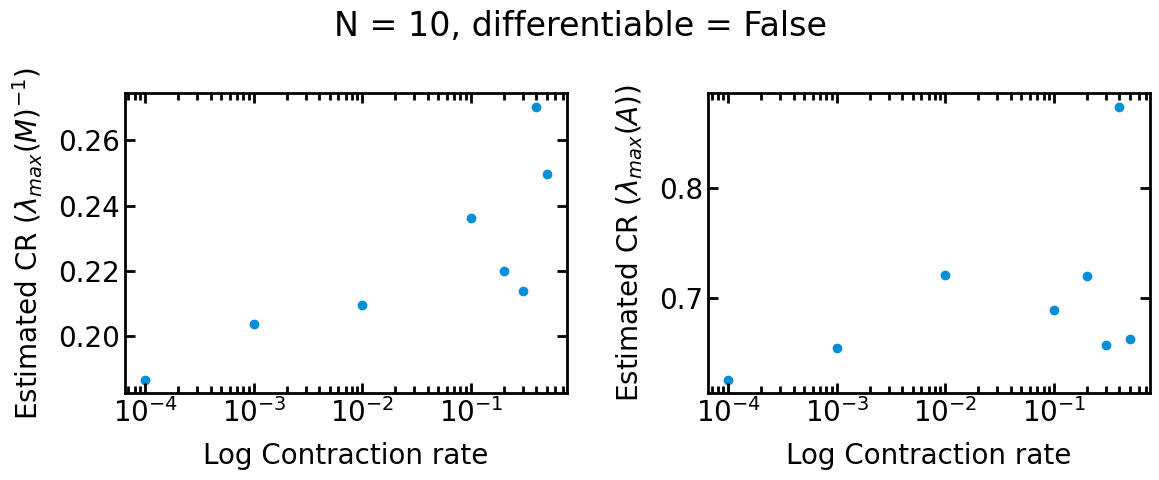

In [122]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter([lamb for lamb in results.keys()], [ret['contraction_rates'][ret['m_index'], ret['r_index']] for ret in results.values()])
plt.xscale('log')
plt.xlabel('Log Contraction rate')
plt.ylabel(r'Estimated CR ($\lambda_{max}(M)^{-1}$)')

plt.subplot(1, 2, 2)
plt.scatter([lamb for lamb in results.keys()], [ret['max_eigvals_A'][ret['m_index'], ret['r_index']] for ret in results.values()])
plt.xscale('log')
plt.xlabel('Log Contraction rate')
plt.ylabel(r'Estimated CR ($\lambda_{max}(A)$)')

plt.suptitle(f'N = {N}, num_indices={num_indices}, differentiable = {differentiable}')
plt.tight_layout()
plt.show()

In [119]:
[ret['m_index'] for ret in results.values()]

[0, 0, 0, 0, 0, 0, 0, 0]